In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [5]:
SEQ_LEN = 128
W, H = 50, 50

data_input = lambda: pong.games_generator(W, H, SEQ_LEN)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32, tf.bool)),
).batch(bs)

In [6]:
X, Y = list(make_dataset(64).take(1))[0]
(directions, controls), (frames, game_over) = X, Y

directions.shape, controls.shape, frames.shape, game_over.shape

W1009 20:44:21.446294 139620787255104 deprecation.py:323] From /home/izpc/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(TensorShape([Dimension(64)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(2)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(50), Dimension(50)]),
 TensorShape([Dimension(64), Dimension(128)]))

In [34]:
class Model:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None
        direction_inp = tf.keras.layers.Input(shape=(1), name='dir_input', batch_size=bs)
        user_input = tf.keras.layers.Input(shape=(None, 2), name='user_input', batch_size=bs)

        self.hidden_direction = tf.keras.layers.Dense(
            200,
            name='hidden_direction',
            activation='relu'
        )

        self.activation_direction = tf.keras.layers.Dense(
            200,
            name='activation_direction',
            activation='relu'
        )

        self.transformed_user_input = tf.keras.layers.LSTM(
            200,
            return_sequences=True,
            name='transformed_user_input',
            activation='relu'
        )

        self.x1 = tf.keras.layers.LSTM(
            200,
            return_sequences=True,
            name='x',
            stateful=stateful,
            activation='relu'
        )

        self.x2 = tf.keras.layers.LSTM(
            200, return_sequences=True, name='x2',
            stateful=stateful,
            activation='relu'
        )
        self.x3 = tf.keras.layers.LSTM(
            200, return_sequences=True, name='x3',
            stateful=stateful,
            activation='relu'
        )

        self.frames1 = tf.keras.layers.Dense(W * H, activation='sigmoid')
        self.frames2 = tf.keras.layers.Reshape((-1, W, H), name='frames')

        self.game_over1 = tf.keras.layers.Dense(1)
        self.game_over2 = tf.keras.layers.Lambda(
            lambda i: tf.squeeze(i, [-1], name='game_over')
        )
        
        hd = self.hidden_direction(direction_inp)
        ad = self.activation_direction(direction_inp)
        ui = self.transformed_user_input(user_input)
        x1 = self.x1(ui, initial_state=[ad, hd])
        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)

        self.net = tf.keras.Model([direction_inp, user_input], [f2, g2])

        self.net.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['mse', 'accuracy']
        )
        
    def copy_in_stateful_model(self):
        stateful = Model(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
            
        return stateful

    def init(self, direction):
        direction = np.array(direction).reshape((1, 1))
        self.init_dir = tf.convert_to_tensor(direction, dtype=tf.float32)
        self.first_time = True
        
    def single_step_predict(self, user_input):
        user_input = np.array(user_input).reshape((1, 1, 2))
        user_input = tf.convert_to_tensor(user_input, dtype=tf.float32)
        ui = self.transformed_user_input(user_input)

        if self.first_time:
            self.first_time = False

            hd = self.hidden_direction(self.init_dir)
            ad = self.activation_direction(self.init_dir)
            x1 = self.x1(ui, initial_state=[ad, hd])
        else:
            x1 = self.x1(ui)

        x2 = self.x2(x1)
        x3 = self.x3(x2)
        f1 = self.frames1(x3)
        f2 = self.frames2(f1)
        g1 = self.game_over1(x3)
        g2 = self.game_over2(g1)
        
        return f2.numpy().reshape(50, 50), g2.numpy()

In [42]:
model = Model()
# model.net.summary()

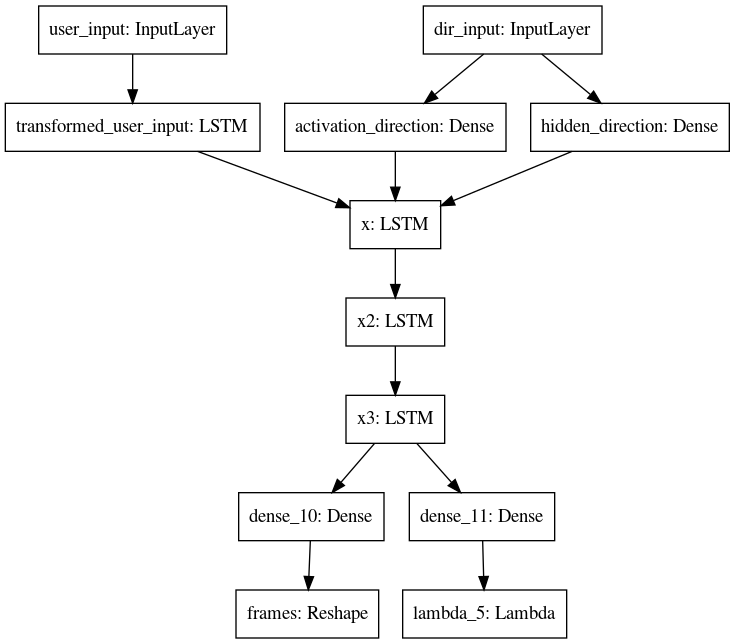

In [43]:
tf.keras.utils.plot_model(model.net, to_file='model.png')

In [44]:
def plot_pairwise_frames(frame_nums):
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames, game_over) = X, Y
    pred_frames, _ = model.net.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [45]:
frame_nums = [1, 4, 8, 16, 32, 64, 127]

In [46]:
class PlotCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, batch, logs=None):
        plot_pairwise_frames(frame_nums)
        plt.show()
        
callbacks = [PlotCallback()]

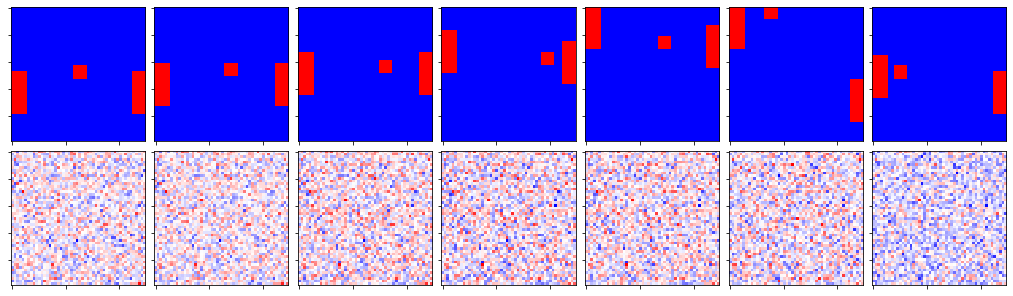

Epoch 1/150
 15/100 [===>..........................] - ETA: 2:09 - loss: 0.8342 - frames_loss: 0.6892 - lambda_5_loss: 0.1450 - frames_mean_squared_error: 0.2480 - frames_acc: 0.8681 - lambda_5_mean_squared_error: 0.0311 - lambda_5_acc: 0.9677

In [ ]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=150,
    callbacks=callbacks
)

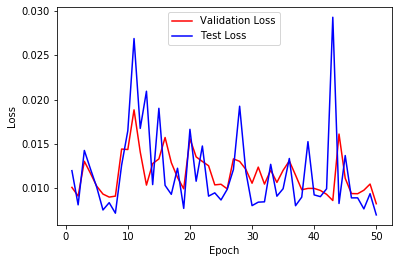

In [53]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

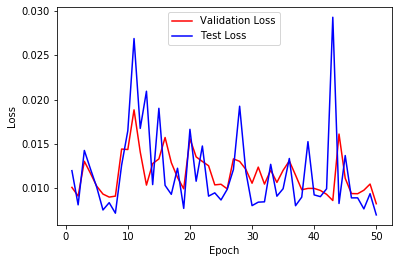

In [54]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [55]:
# plot_pairwise_frames(frame_nums)

In [56]:
# model.net.save('LSTM3_PONG.hdf5')

In [57]:
stateful = model.copy_in_stateful_model()
stateful.init(0.4)
t = 0

stateful.net.save('STATEFUL_LSTM3_PONG_RELU.hdf5')

1

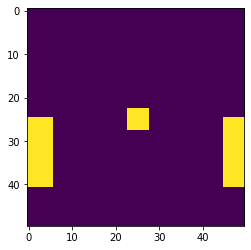

In [58]:
t += 1
frame, _ = stateful.single_step_predict([-1, 1])

plt.imshow(frame > 0.5)
t